In [25]:
%load_ext autoreload
%autoreload 2

# 1. Pre-processing

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier
import pytorch_tabnet.tab_model
import pytorch_tabnet
import pytorch_tabnet.tab_network
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline
import importlib

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())
    
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)
        
        
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

con_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]

'''
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
'''
base_auc = 0.9275363726026278
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0

base_auc_2 = 0.9313200431309823
base_acc_2 = 0.8754208754208754
beat_auc_2 = 0
beat_acc_2 = 0

'''
EXPLAIN:
    - base_auc: roc auc score of the pretrained version of original model
    - base_auc_2: roc auc score of the TabNet modified version with no pretraining
    => Now we test the TabNet modified version with pretraining
'''

#### Customized train, valid, test
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

acc = []
auc = []

'''
First, I test with the same model, with con embedding in the TabNet pretrainer, and with con embedding in TabNet classifier.
'''
for i in range(34, 35):
    # TabNetPretrainer
    unsupervised_model = TabNetPretrainer(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=1,
        con_idxs=con_idxs,
        con_emb_dim=i,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='entmax', # "sparsemax",
        n_shared_decoder=1, # nb shared glu for decoding
        n_indep_decoder=1, # nb independent glu for decoding
    )
    max_epochs = 1000 if not os.getenv("CI", False) else 2

    unsupervised_model.fit(
        X_train=X_train,
        eval_set=[X_valid],
        max_epochs=max_epochs , patience=5,
        batch_size=2048, virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        pretraining_ratio=0.8,

    ) 
    max_epochs = 7700 if not os.getenv("CI", False) else 2


    clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=2e-2),
                           scheduler_params={"step_size":50, # how to use learning rate scheduler
                                             "gamma":0.9},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='entmax' # "sparsemax"
                          )

    clf.fit(
            X_train=X_train, y_train=y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_name=['train', 'valid'],
            eval_metric=['auc'],
            max_epochs=max_epochs , patience=20,
            batch_size=1024, virtual_batch_size=128,
            num_workers=0,
            weights=1,
            drop_last=False,
            from_unsupervised=unsupervised_model
            )
    preds_class = clf.predict(X_test)
    preds = clf.predict_proba(X_test)
    test_acc = accuracy_score(y_test, preds_class)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
    print("with con_emb_dim =", i)
    print("acc:", test_acc)
    print("auc:", test_auc)
    auc.append(test_auc)
    acc.append(test_acc)
    if test_acc > base_acc: 
        print("Beat ACC 1")
        beat_acc = 1
    if test_auc > base_auc: 
        print("Beat AUC 1")
        beat_auc = 1
    if test_acc > base_acc_2: 
        print("Beat ACC 2")
        beat_acc_2 = 1
    if test_auc > base_auc_2: 
        print("Beat AUC 2")
        beat_auc_2 = 1

File already exists.
39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3
Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 4.7578  | val_0_unsup_loss: 5.42689 |  0:00:03s
epoch 1  | loss: 3.44944 | val_0_unsup_loss: 3.62125 |  0:00:06s
epoch 2  | loss: 3.3689  | val_0_unsup_loss: 3.4129  |  0:00:09s
epoch 3  | loss: 3.34964 | val_0_unsup_loss: 3.36405 |  0:00:12s
epoch 4  | loss: 3.35031 | val_0_unsup_loss: 3.3633  |  0:00:16s
epoch 5  | loss: 3.34318 | val_0_unsup_loss: 3.35512 |  0:00:21s
epoch 6  | loss: 3.34237 | val_0_unsup_loss: 3.36945 |  0:00:24s
epoch 7  | loss: 3.33881 | val_0_unsup_loss: 3.3529  |  0:00:28s
epoch 8  | loss: 3.3416  | val_0_unsup_

D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_emb_dim changed from 1 to 34
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_idxs changed from [] to [2]
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90877 | train_auc: 0.75697 | valid_auc: 0.772   |  0:00:04s
epoch 1  | loss: 0.54827 | train_auc: 0.76917 | valid_auc: 0.76298 |  0:00:08s
epoch 2  | loss: 0.50082 | train_auc: 0.83167 | valid_auc: 0.82446 |  0:00:13s
epoch 3  | loss: 0.46849 | train_auc: 0.85634 | valid_auc: 0.85401 |  0:00:20s
epoch 4  | loss: 0.43441 | train_auc: 0.87722 | valid_auc: 0.87462 |  0:00:26s
epoch 5  | loss: 0.42076 | train_auc: 0.87541 | valid_auc: 0.87083 |  0:00:30s
epoch 6  | loss: 0.39564 | train_auc: 0.88805 | valid_auc: 0.88803 |  0:00:34s
epoch 7  | loss: 0.38415 | train_auc: 0.90011 | valid_auc: 0.90003 |  0:00:39s
epoch 8  | loss: 0.37369 | train_auc: 0.90975 | valid_auc: 0.90873 |  0:00:43s
epoch 9  | loss: 0.35864 | train_auc: 0.91533 | valid_auc: 0.91129 |  0:00:47s
epoch 10 | loss: 0.358   | train_auc: 0.9198  | valid_auc: 0.91502 |  0:00:51s
epoch 11 | loss: 0.34727 | train_auc: 0.91662 | valid_auc: 0.91163 |  0:00:55s
epoch 12 | loss: 0.34665 | train_auc: 0.92387 | vali

In [5]:
acc

[0.8334863789409244,
 0.8157330884603612,
 0.8233853688399143,
 0.7884909703091522,
 0.8448117539026629,
 0.8050198959289868,
 0.8249158249158249,
 0.8285889194980104,
 0.8353229262320171,
 0.8328741965105602,
 0.8132843587389041,
 0.8108356290174472,
 0.8429752066115702,
 0.8331802877257423,
 0.8383838383838383,
 0.8117539026629935,
 0.8230792776247322,
 0.7964493419038874,
 0.8426691153963881,
 0.8313437404346495,
 0.825221916131007,
 0.837465564738292,
 0.8310376492194674,
 0.8344046525864708,
 0.8233853688399143,
 0.8298132843587389,
 0.8319559228650137,
 0.8307315580042853,
 0.8181818181818182,
 0.8441995714722987,
 0.8405264768901133,
 0.8457300275482094,
 0.8273645546372819,
 0.8243036424854606,
 0.8243036424854606,
 0.8282828282828283,
 0.8328741965105602,
 0.8292011019283747,
 0.8261401897765535,
 0.8432812978267523,
 0.7692072237526782,
 0.8396082032445669,
 0.8184879093970003,
 0.8411386593204775,
 0.8102234465870829,
 0.8212427303336394,
 0.8356290174471993,
 0.870829507193

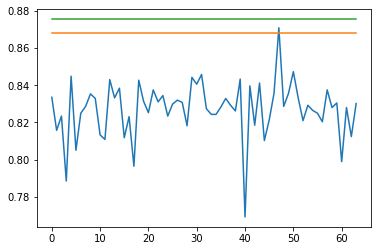

In [3]:
## CLASSIFICATION REPORT ##

base_acc_plot = [base_acc]*len(acc)
base_acc_plot_2 = [base_acc_2]*len(acc)
plt.plot(acc)
plt.plot(base_acc_plot)
plt.plot(base_acc_plot_2)

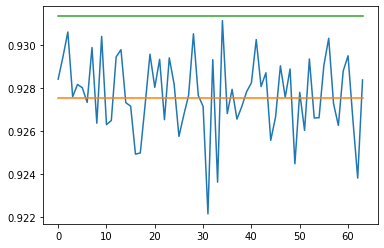

In [4]:
## CLASSIFICATION REPORT ##

base_auc_plot = [base_auc]*len(auc)
base_auc_plot_2 = [base_auc_2]*len(auc)
plt.plot(auc)
plt.plot(base_auc_plot)
plt.plot(base_auc_plot_2)

In [6]:
auc

[0.9284066577065969,
 0.9294468604835371,
 0.9305900359254509,
 0.9275890087539541,
 0.9281608519902087,
 0.9280070317809925,
 0.92732940521149,
 0.9298676941788504,
 0.9263653459932646,
 0.930387412294374,
 0.926300189592351,
 0.9264882488514588,
 0.9294338292033545,
 0.9297700873351289,
 0.9273163739313073,
 0.9271546327478626,
 0.9249321606884605,
 0.9249868409621684,
 0.9272251549700281,
 0.9295610758216094,
 0.928026450943618,
 0.9293229355641522,
 0.926529897844984,
 0.9293924357251269,
 0.9281705615715212,
 0.9257544089164619,
 0.9267422310573734,
 0.9276605530373104,
 0.9305090375760797,
 0.9276508434559977,
 0.9271433900747638,
 0.9221628858919784,
 0.9293088822227786,
 0.9236346540067355,
 0.9311197191375846,
 0.9268117312183481,
 0.9279344654364458,
 0.9265557048900517,
 0.9271306143098788,
 0.9278215276748619,
 0.9282375065795189,
 0.9302392134217076,
 0.9280622230852961,
 0.9287022889060368,
 0.9255724820244988,
 0.9266584220397275,
 0.9290224495740558,
 0.9275655013465656

In [10]:
max_auc = max(auc)
print("Max auc =", max_auc, 'with con_emb_dim =', auc.index(max_auc))

Max auc = 0.9311197191375846 with con_emb_dim = 34


# 2. Pretraining

In [17]:
'''
First, I test with the same model, with con embedding in the TabNet pretrainer, and with con embedding in TabNet classifier.
'''

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    con_idxs=con_idxs,
    con_emb_dim=44,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
)
max_epochs = 1000 if not os.getenv("CI", False) else 2

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,

) 




unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 4.66177 | val_0_unsup_loss: 33.05913|  0:00:03s
epoch 1  | loss: 3.59719 | val_0_unsup_loss: 3.79561 |  0:00:07s
epoch 2  | loss: 3.51866 | val_0_unsup_loss: 3.55959 |  0:00:10s
epoch 3  | loss: 3.5048  | val_0_unsup_loss: 3.52008 |  0:00:13s
epoch 4  | loss: 3.50758 | val_0_unsup_loss: 3.51358 |  0:00:16s
epoch 5  | loss: 3.49703 | val_0_unsup_loss: 3.51498 |  0:00:19s
epoch 6  | loss: 3.5017  | val_0_unsup_loss: 3.5127  |  0:00:22s
epoch 7  | loss: 3.50195 | val_0_unsup_loss: 3.51231 |  0:00:26s
epoch 8  | loss: 3.50254 | val_0_unsup_loss: 3.51241 |  0:00:29s
epoch 9  | loss: 3.50191 | val_0_unsup_loss: 3.51281 |  0:00:33s
epoch 10 | loss: 3.50326 | val_0_unsup_loss: 3.5132  |  0:00:37s
epoch 11 | loss: 3.50165 | va

In [18]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [19]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

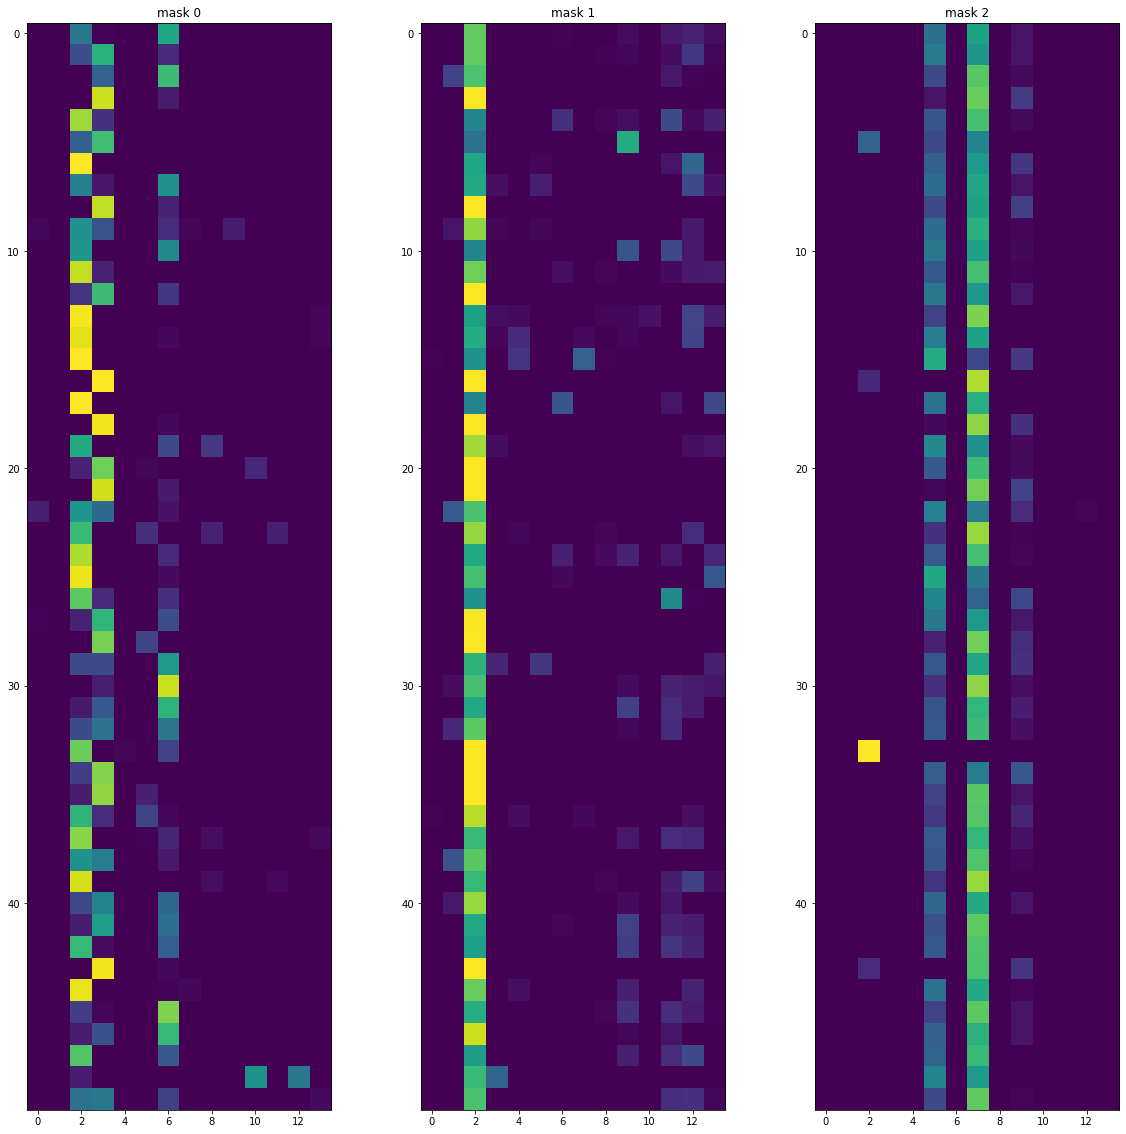

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [21]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip
Device used : cpu
Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14


In [22]:
unsupervised_model.get_params()

{'cat_dims': [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42],
 'cat_emb_dim': 1,
 'cat_idxs': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'clip_value': 1,
 'con_emb_dim': 44,
 'con_idxs': [2],
 'device_name': 'auto',
 'dropout': 1,
 'embed_dim': 512,
 'epsilon': 1e-15,
 'forward_expansion': 1,
 'gamma': 1.3,
 'heads': 1,
 'input_dim': 14,
 'lambda_sparse': 0.001,
 'mask_type': 'entmax',
 'momentum': 0.02,
 'n_a': 8,
 'n_d': 8,
 'n_indep_decoder': 1,
 'n_independent': 2,
 'n_shared': 2,
 'n_shared_decoder': 1,
 'n_steps': 3,
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02},
 'output_dim': None,
 'scheduler_fn': None,
 'scheduler_params': {},
 'seed': 0,
 'verbose': 1}

In [23]:
loaded_pretrain

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, con_idxs=[2], con_emb_dim=44, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=14, output_dim=None, embed_dim=512, dropout=1, forward_expansion=1, heads=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [30]:
unsupervised_model

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, con_idxs=[2], con_emb_dim=44, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=14, output_dim=None, embed_dim=512, dropout=1, forward_expansion=1, heads=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

# 3. Classifier

In [24]:
max_epochs = 7700 if not os.getenv("CI", False) else 2


clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       con_idxs = con_idxs,
                       con_emb_dim = 44,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        from_unsupervised=loaded_pretrain
        )


Device used : cpu
In abstract_model.py, _set_network, con_idxs =  [2]
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
Loading weights from unsupervised pretraining

epoch 0  | loss: 0.66077 | train_auc: 0.76754 | valid_auc: 0.77087 |  0:00:04s
epoch 1  | loss: 0.5347  | train_auc: 0.79645 | valid_auc: 0.81212 |  0:00:08s
epoch 2  | loss: 0.51987 | train_auc: 0.80856 | valid_auc: 0.82314 |  0:00:13s
epoch 3  | loss: 0.51089 | train_auc: 0.81031 | valid_auc: 0.81654 |  0:00:17s
epoch 4  | loss: 0.48986 | train_auc: 0.83501 | valid_auc: 0.84217 |  0:00:21s
epoch 5  | loss: 0.48396 | train_auc: 0.85228 | valid_auc: 0.85795 |  0:00:26s
epoch 6  | loss: 0.46393 | train_auc: 0.86542 | valid_auc: 0.86928 |  0:00:30s
epoch 7  | loss: 0.44523 | train_auc: 0.87567 | valid_auc: 0.87684 |  0:00:34s
epoch 8  | loss: 0.43637 | train_auc: 0.88333 | valid_auc: 0.8875  |  0:00:39s
epoch 9  | loss: 0.41604 | train_auc: 0.8941

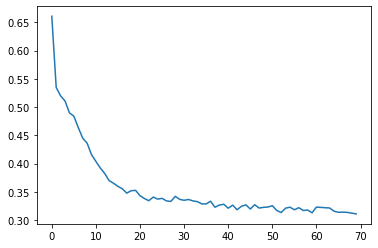

In [25]:
# plot losses
plt.plot(clf.history['loss'])

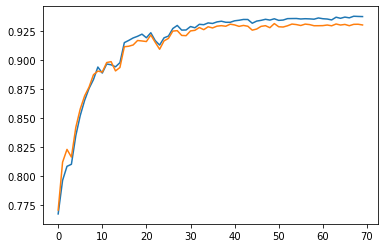

In [26]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

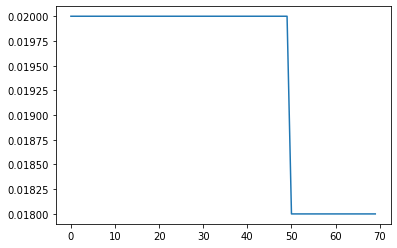

In [27]:
# plot learning rates
plt.plot(clf.history['lr'])

In [28]:
preds_class = clf.predict(X_test)
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_test, preds_class)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print("acc:", test_acc)
print("auc:", test_auc)

acc: 0.8411386593204775
auc: 0.9287022889060368


In [22]:
clf.feature_importances_

AttributeError: 'TabNetClassifier' object has no attribute 'feature_importances_'